In [55]:
# Install dataset
!pip install -q kagglehub scikit-fuzzy

import kagglehub
dataset_path = kagglehub.dataset_download("paultimothymooney/blood-cells")
print("Dataset path:", dataset_path)

Using Colab cache for faster access to the 'blood-cells' dataset.
Dataset path: /kaggle/input/blood-cells


In [56]:
# Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from skimage.segmentation import find_boundaries

In [57]:
dataset_root = "/kaggle/input/blood-cells"

image_paths = []

for root, dirs, files in os.walk(dataset_root):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(root, file))

print("Total images collected:", len(image_paths))
# Use subset for speed
MAX_IMAGES = 800
image_paths = image_paths[:MAX_IMAGES]

IMG_SIZE = 256

Total images collected: 12881


In [58]:
# Boundary accuracy metric
def boundary_accuracy(seg1, seg2):
    b1 = find_boundaries(seg1, mode='inner')
    b2 = find_boundaries(seg2, mode='inner')
    return np.sum(b1 == b2) / b1.size

In [59]:
# We are not doing hyperparameter tuning here because we already know that
# white blood cell images mainly contain three regions: background,
# cytoplasm and nucleus. So we fix the number of clusters to 3.
# For Fuzzy C-Means, the standard fuzziness value m = 2.0 is commonly
# used in literature and works well in most cases.

k_clusters = 3
fuzziness_m = 2.0

In [61]:
boundary_scores = []
results = []
for img_path in tqdm(image_paths):

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.GaussianBlur(img, (5,5), 0)

    pixels = img.reshape((-1, 1)).astype(np.float32)

    # K-Means (hard clustering)
    kmeans = KMeans(n_clusters=k_clusters, n_init=10)
    labels_k = kmeans.fit_predict(pixels)
    seg_k = labels_k.reshape((IMG_SIZE, IMG_SIZE))

    # Fuzzy C-Means (soft clustering)
    data = pixels.T
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data, c=k_clusters, m=fuzziness_m, error=0.005, maxiter=500
    )
    labels_f = np.argmax(u, axis=0)
    seg_f = labels_f.reshape((IMG_SIZE, IMG_SIZE))

    boundary_scores.append(boundary_accuracy(seg_k, seg_f))
    results.append((img, seg_k, seg_f))

print("\nMean Boundary Agreement:", np.mean(boundary_scores))

100%|██████████| 800/800 [21:37<00:00,  1.62s/it]


Mean Boundary Agreement: 0.9300936317443848


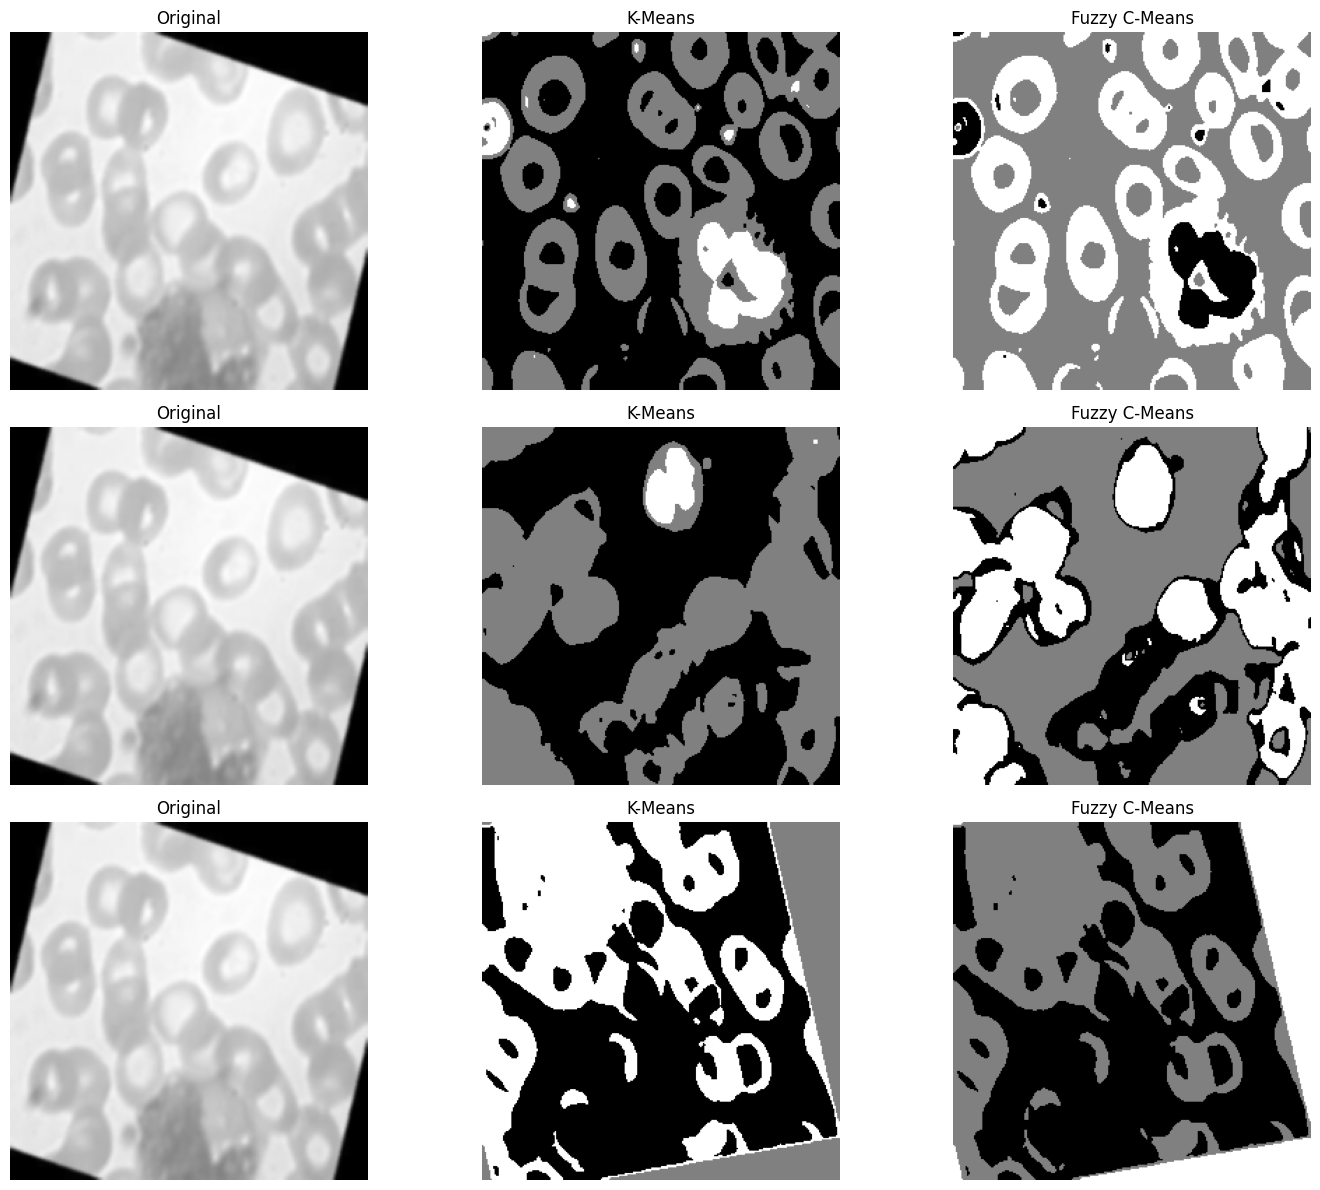

In [62]:
# Select 3 random processed outputs
import random
sample_results = random.sample(results, 3)

plt.figure(figsize=(15, 12))

for i, (img_rgb, seg_k, seg_f) in enumerate(sample_results):

    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(seg_k, cmap='gray')
    plt.title("K-Means")
    plt.axis("off")

    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(seg_f, cmap='gray')
    plt.title("Fuzzy C-Means")
    plt.axis("off")

plt.tight_layout()
plt.show()